# Exercise 4
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

In [56]:
import os
import sys
import copy
import zipfile
import time
import random
import collections
import numpy as np
from PIL import Image
import pickle
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms 

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print(torch.__version__)

%load_ext autoreload
%autoreload 2

1.13.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Recurrent Neural Networks (40 points)

Understanding and implementing the vanilla RNN cell. As you learned in class, the RNN has a certain structure that allows it to accept the previous hidden state the current input, and output an hidden state and an output vector. The RNN cell uses the same weights for all time steps, much like convolution uses the same weights for all the batches in the image. Even though you already are familiar with PyTorch, implementing the RNN you make sure you understand how this pivotal architecture works.

## Helper functions

In [57]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

# Vanilla RNN: step forward (10 points)

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors less than 1e-7.

In [93]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a vanilla RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    ##############################################################################
    # TODO: Implement a single forward step for the vanilla RNN. Store the next  #
    # hidden state and any values you need for the backward pass in the next_h   #
    # and cache variables respectively.                                          #
    ##############################################################################
    
    next_h = np.tanh(x @ Wx + prev_h @ Wh + b.reshape(1,b.size))
    cache = (next_h, x, prev_h, Wx, Wh)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return next_h, cache

In [94]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward (10 points)

In [102]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a single step of a vanilla RNN.      #
    #                                                                            #
    # HINT: For the tanh function, you can compute the local derivative in terms #
    # of the output value from tanh.                                             #
    ##############################################################################

    # slide 83
    # derive the bias db also in this case

    
    next_h, x, prev_h, Wx, Wh = cache 

    dtanh = (1 - (next_h ** 2)) * dnext_h 
    dx = dtanh @ Wx.T
    dprev_h = dtanh @ Wh.T
    dWx = x.T @ dtanh
    dWh = prev_h.T @ dtanh
    db = np.sum(dtanh, axis=0) # need to derive bias here 

    
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dprev_h, dWx, dWh, db

In [103]:
np.random.seed(1337)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.2389924368419153e-10
dprev_h error:  1.998548787839473e-08
dWx error:  8.09329219849245e-10
dWh error:  9.131782428817678e-10
db error:  6.240559767218964e-10


# Vanilla RNN: forward (10 points)
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that process an entire sequence of data.

In [105]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a vanilla RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    
    N, T ,D = x.shape
    
    h = np.empty(shape=(N,T,b.size))
    prev_h = h0

    for t in range(T):
        prev_h, _ = rnn_step_forward(x=x[:,t,:], prev_h = prev_h, Wx=Wx, Wh=Wh, b=b)
        h[:,t,:] = prev_h

    cache = (h, x, h0, Wx, Wh)

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

In [106]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


# Vanilla RNN: backward (10 points)

In [136]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a vanilla RNN running an entire      #
    # sequence of data. You should use the rnn_step_backward function that you   #
    # defined above. You can use a for loop to help compute the backward pass.   #
    ##############################################################################

    
    # for loop, use cache, but also update derivs at each step unlike forward 

    next_h, x, h0, Wx, Wh = cache 
    D = x.shape[-1]
    
    dx = np.empty((N,T,D))
    dh0 = np.zeros_like(h0)
    dWx = np.zeros((D,H))
    dWh = np.zeros((H,H))
    db = np.zeros((H,))
    dprev_h = np.zeros((N,H))


    for t in reversed(range(T)): #range(T -1, -1, -1):
        dh0 += dh[:, t, :]
        dnext_h = dh[:, t, :] + dprev_h
        cache_t = (next_h[:,t,:], x[:,t,:], next_h[:,t-1,:], Wx, Wh)
        # update derivatives at each step unlike in forward loop 
        dx[:, t, :], dh0, dWx_t, dWh_t, db_t = rnn_step_backward(dnext_h=dh0, cache=cache_t)
        dWx += dWx_t
        dWh += dWh_t
        db += db_t
    

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dh0, dWx, dWh, db

In [137]:
np.random.seed(1337)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.5454005651479204e-09
dh0 error:  5.550869993700242e-10
dWx error:  3.6923303213730454e-09
dWh error:  1.0
db error:  4.904391261362268e-10


## Questions

##**Question:** 
When using valina RNN on long sequences, what could happen? What causes this to happen?   **(5 Points)**

**Your answer:** *Using vanilla RNN on long sequences can cause several issues or shortfalls. One classic issue is exploding (or vanishing) gradients, which happens in the backprop phase as multiple matrices are cross-multiplied 'multiple' times, and this can lead to the network not learning properly or optimizing, and leads to either very slow or unstable learning in the extreme cases. Another critical issue is the lack of context resulting from the long sequence and losing some degree of information on bits in further back in the beginning of the sequence, as the RNN layer are applied for the length of the sequence. An extension of the problem of exploding or vanishing gradients is their effect on the complexity of the network, causing issues with computational and memory complexity, placing bottlenecks on the leanring and training process, and making the models less scalable and practically useful. *


##**Question:** 
Could this problem be solved by a different model? How does it accomplish this?   **(5 Points)**

**Your answer:** *Using LSTM, or Long Short-Term Memory helps to address some of these issues, especially the context issue, as it is an architecture better suited for long sequences. The built-in memory cell in LSTMs can store more information and control the flow of information in and out of the cell, which allows to retain more critical information from the beginning or farther back parts of the sequences, while also selectively forgetting or deprioritizing less helpful or useful bits of information, and this also addresses the issues with gradients. The LSTM gates - the input gate, forget gate, and output gate all work together to regulate and selectively prioritize that flow of information.*


# Building Image Captioning in PyTorch (50 points)

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we need to extract meaningful features regarding the image that would help us describe it. Second, we need to generate a sequence of words that best fit those features. Luckily, the flexability of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network. We only need to provide proper labels to train the new network we created. For this exercise, you will be provided with pretrained networks for both feature extraction and sentence generation, and you will connect the different components needed to make image captioning work.

First, we define the feature extractor and the recurrent model seperately. The feature extractor takes an image and produces a vector representation of the image features. As those features hold information about the image, we will use that vector as the input for our recurrent model. The RNN will produce the image captioning using an LSTM architecture. 

In [66]:
# unzipping the pretrained models
with zipfile.ZipFile(os.path.join('models', 'pretrained_model.zip'), 'r') as zip_ref:
    zip_ref.extractall('models')

In [67]:
# unzipping vocabulary
with zipfile.ZipFile(os.path.join('data', 'vocab.zip'), 'r') as zip_ref:
    zip_ref.extractall('data')

In [68]:
conv_path = 'models/encoder-5-3000.pkl'
lstm_path = 'models/decoder-5-3000.pkl'
vocab_path   = 'data/vocab.pkl'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the following code to check if all the files are in place
print("conv_path ", '✓' if os.path.isfile(conv_path) == True else '✗') 
print("lstm_path ", '✓' if os.path.isfile(lstm_path) == True else '✗') 
print("vocab_path ", '✓' if os.path.isfile(vocab_path) == True else '✗') 

conv_path  ✓
lstm_path  ✓
vocab_path  ✓


## Implementing image captioning model **(40 points)**.

As training a multimodal classifier could take some time and resources, we spared you the training phase this time. In this exercise, we use a pretrained model to solve the image captioning task. Using pretrained models is a common practice in the deep learning community and it's important to be aware of such techniques to save time and energy. In previous cells, we unzipped the necessary files, but in order to be able to load the models (and then use them) it is required to build the same PyTorch model as the pretrained model.

**ConvNet architecture:** resnet152 (without last fc layer) -> fc layer -> BatchNorm1d

**LSTM architecture:** LSTM -> linear -> embed

We added more detailed instructions in the next cells, please make sure you follow them carefully. 

**Please make sure you construct your models based on the sizes we provided.**

In [69]:
embed_size   = 256      # dimension of word embedding vectors
hidden_size  = 512      # dimension of lstm hidden states
num_layers   = 1        # number of layers in lstm

In [248]:
class ConvNet(nn.Module):
    def __init__(self, embed_size):
        super(ConvNet, self).__init__()
        resnet = models.resnet152() # construct an nn.Sequential model without the last resnet152 layer
        # make sure you define each of the None parameters
        self.linear = None
        self.bn = None
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-152 network and replace the top fully          #
        # connected layer, so we could pass the features of the network and not the #
        # classification head which carries significantly less information.         #
        # Afterwards, create a new sequential model which includes the resnet and   #
        # add a new fully connected layer that outputs a vector with the size of    #
        # the wanted embedding. Next, you should add a batchnorm layer with         #
        # momentum=0.01 (BatchNorm1d parameter).                                    #
        # This function has no return value.                                        #
        #############################################################################

        # similar to hw3, cut the head off ResNet 
        # but add batchnorm layer w momentum nn.momentum or some shit nn.batchnorm 
        np.random.seed(0)

        for param in resnet.parameters():
            param.requires_grad = False

        

        resnet = list(resnet.children())# [:-1] # 'cut off the head' of the ResNet similar to hw3
        resnet, res_fc = resnet[:-1], resnet[-1]
        in_feat = res_fc.in_features

        self.resnet = nn.Sequential(*resnet)
        self.linear = nn.Linear(in_features=in_feat, out_features=embed_size)
        self.bn = nn.BatchNorm1d(num_features=embed_size, momentum=0.01) # adding BN layer w mom=0.01 as instructed
        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # perdefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training. Make sure you are inputing a correct shape       #
        # to the batchnorm layer.                                                   #
        # This function returns the features of the image.                          #
        #############################################################################


        features = self.resnet(images)
        features = nn.Flatten()(features) # to make sure inputting correct shape for BN layer
        features = self.linear(features)
        features = self.bn(features)

        return features 
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################


class LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(LSTM, self).__init__()
        self.max_seg_length = max_seq_length
        self.embed = None
        self.lstm = None
        self.linear = None
        #############################################################################
        # TO DO:                                                                    #
        # Define the hyper-parameters and the layers of the pretrained LSTM.        #
        # Create an Embedding layer that accepts the output of the                  #
        # feature extractor.  Next, the built-in LSTM architecture in PyTorch.nn    #
        # with the proper inputs (use the built-in documentation tool in Jupyter    #
        # or just look at the official documentation online).                       #
        # Define an additional linear layer that comes after the LSTM and outputs   #
        # a vector that will support the size of our vocabulary.                    #
        # This function has no return value.                                        #
        #############################################################################

        # long sequences first words less important so context handles that 
        # use PyTorch embedding layer nn.embedding nn.LSTM 
        # embedding - pass a word - embedding will take the word and output the word in vector dimension provided 
        # debated embedding > LSTM > linear or LSTM > embedding > linear? 

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(in_features=hidden_size, out_features=vocab_size)


        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################           
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        #############################################################################
        # TO DO:                                                                    #
        # Generate captions for a given image features.                             #
        # First, obtain the output of the LSTM network.        #
        # Next, use the hidden states to obtain the most probable word and store    #
        # all the word predictions in the sampled_ids list. Don't forget to update  #
        # the inputs for each timestep to continue making predictions based on the  #
        # words you are alreaedy predicted.                                         #
        # Make sure you keep track of the dimensions of the inputs and outputs,     #
        # since PyTorch expects tensors with a batch dimension. You can use the     #
        # methods .squeeze() and .unsqueeze()                                       #
        # This function returns the list of predicted words.                        #
        #############################################################################
        
        # generate a softmax with dictionary size...softmax vector 10K inputs,  argmax is word that maximizes 
        states = (torch.zeros(self.num_layers, 1, self.hidden_size).to(inputs.device),
                  torch.zeros(self.num_layers, 1, self.hidden_size).to(inputs.device))
        for _ in range(self.max_seg_length):
            x, states = self.lstm(inputs, states) # LSTM output 
            output = self.linear(x) # each word's output score 
            output = output.squeeze(1)
            word_pred = output.argmax(1)

            sampled_ids.append(word_pred.item())
            inputs = self.embed(word_pred.unsqueeze(0))

        sampled_ids = torch.Tensor(sampled_ids).unsqueeze(0)

        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################        

        return sampled_ids

In [249]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.Resampling.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [250]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [251]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [254]:
# Build models
conv = ConvNet(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
lstm = LSTM(embed_size, hidden_size, len(vocab), num_layers)
conv = conv.to(device)
lstm = lstm.to(device)

# Load the trained model parameters
conv.load_state_dict(torch.load(conv_path))
lstm.load_state_dict(torch.load(lstm_path))

# Prepare an image
image_path = os.path.join('data', 'pic.jpg')
image = load_image(image_path, transform)
image_tensor = image.to(device)

<start> a clock tower with a clock on top of it . <end>


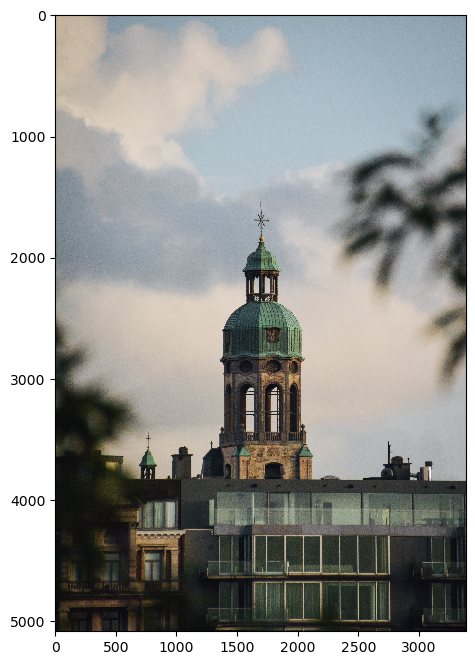

In [255]:
# Generate an caption from the image
feature = conv(image_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print(sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image));

## Questions

##**Question:** 
Could you think of a method to evalute the goodness of the captioning model? **(5 Points)**

**Your answer:** 
There are several evaluation metrics to evaluate the goodness of image captioning models. Below is a listing of a few common alternatives: 

BLEU: this computes the n-gram overlap between the predicted caption and ground truth captions.

ROUGE: this is similar to BLEU, but in addition it also takes in consideration the sentence-level recall and F1 scores.

METEOR: considers both unigram precision and recall, as well as synonymy, stemming, and stopword filtering.

CIDEr: factors the n-gram overlap and semantic similarity between predicted and ground truth captions.

SPICE: this evaluates using the semantic and syntactic similarity, as well as coherence and diversity of the generated captions.

The above metrics are used to calculate the similarity between the generated captions and ground truth captions. Different metrics are more appropriate depending on the task and outcomes of importance. 


##**Question:** 
Could you think of scenarios where the model fails? Why would that happen? **(5 Points)**

We encourage you to test it on different images (jpg). 

### See different image tests in sections that follow 

**Your answer:** *Fill this in*
There are many reasons why image captioning models can fail, including: 
- Image quality - garbage in, garbage out, tough to recognize or make sense of the image if it's poor quality; can also be backgrounds that complicate the image, or ambiguous or unknown objects that will deter the model from learning or recognizing properly. There are countless image quality issues that can influence model performance and cause failure. 
- Complicated convoluted images - some images can even be difficult for humans to decipher, same for machines and NN's 
- sensitivity to random weight initializations 
- easy to overfit b/c of requiring more paramaters than a simple 1D CNN, as well as more memory to train
- Out-of-vocabulary words - If the model encounters words that are not in its training vocabulary, it may fail to generate a caption that accurately describes the image.

## Extra picture fun

<start> a man and woman standing in front of a crowd of people . <end>


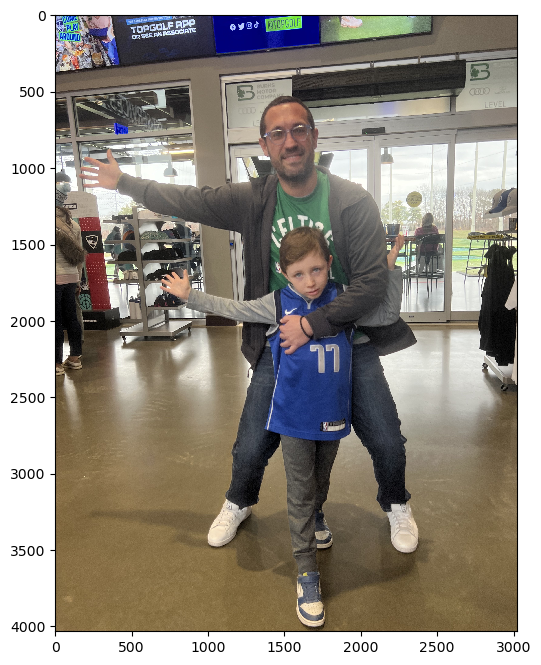

In [256]:
image_path = os.path.join('data', 'levybday.jpg')
image = load_image(image_path, transform)
image_tensor = image.to(device)
feature = conv(image_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)
print(sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image));


<start> a man and woman are eating a meal at a table . <end>


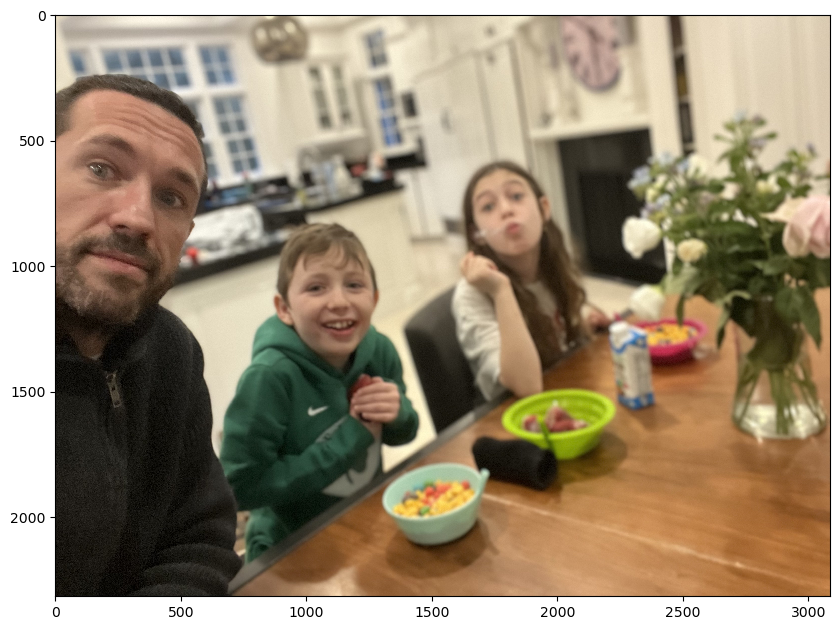

In [259]:
image_path = os.path.join('data', 'laylev.jpg')
image = load_image(image_path, transform)
image_tensor = image.to(device)
feature = conv(image_tensor)
sampled_ids = lstm.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)
print(sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image));
